In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import warnings
import statsmodels.api as sm
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

In [7]:
pct_close = pd.read_parquet("../../db/tw/pdata/cl_pct.parquet")
pct_close = pct_close.pct_change().dropna(how='all')
pct_close.index = pd.to_datetime(pct_close.index)
pct_close_w = pct_close.resample("W-FRI").sum()
def third_friday(date):
    month = date.month
    year = date.year
    first_day_of_month = pd.Timestamp(year, month, 1)
    first_friday = first_day_of_month + pd.offsets.Week(weekday=4)
    third_friday = first_friday + pd.offsets.Week(2)
    return third_friday

zero = pd.read_csv("0050.csv")
zero['true'] = zero['年月'].apply(lambda x: int(str(x).split("/")[1]) % 3 == 0)
zero['ticker'] = zero['標的碼'].astype(str).apply(lambda x: len(x) == 4 and x != "TT99" and x != 'MTSE')
holdings = zero[(zero['true'] == True) & (zero['ticker'] == True)]
holdings = holdings.set_index("年月")
holdings.index = pd.to_datetime(holdings.index)
holdings = holdings[holdings.index >= '2020-01-01']
try:
    holdings['標的碼'].astype(int)
except ValueError as e:
    print(e)

date_3fri = [None] * len(holdings)
for ind, i in enumerate(holdings.index):
    date_3fri[ind] = third_friday(i)
da = "da"
holdings[da] = date_3fri
holdings.set_index(da, inplace=True)
holdings.sort_index(ascending=True, inplace=True)

In [9]:
from arch import arch_model

def get_df_factor_garch(pct_close_w, start, end, list_):
    pct_to_be_used = pct_close_w.loc[start-timedelta(days=365):end]
    pct_to_be_predicted = pct_close_w.loc[start:end].index
    
    indexes = pct_to_be_used.index
    tickers = list_
    ticker_len = len(list_)
    indices = indexes[52:]
    forecast = np.zeros((len(indices), len(tickers)))
    for index, date in enumerate(tqdm(indices, desc=f"arma model for top {ticker_len}, {start} to {end}, enumerate by da")):
        pct_train = pct_close_w.loc[indexes[index]:date]
        for i in range(ticker_len):
            try:
                series = pct_train[tickers[i]]
                if series.isna().any():
                    prediction = 0
                    print(tickers[i], "failed at", date)
                    continue
                    ###### ARIMA ma
                else:
                    model = arch_model(series, p=2)
                    model_fit = model.fit(disp='off')
                    prediction = model_fit.forecast().variance.values[0][0]
            except: 
                prediction = 0
            forecast[index, i] = prediction
    factor = pd.DataFrame(forecast, columns=tickers, index=indices)
    return factor

In [10]:
set_da = sorted(list(set(holdings.index)))
factors = [None] * (len(set_da) - 1)
for i in range(len(set_da)-1):
    start = set_da[i]
    end = set_da[i+1]
    list_ = holdings[holdings.index == start]['標的碼']
    pct_to_be_used = pct_close_w.loc[start-timedelta(days=365-7):end]
    pct_to_be_predicted = pct_close_w.loc[start:end].index
    factor = get_df_factor_garch(pct_close_w, start, end, list_)
    factors[i] = factor.iloc[1:, :]
factor = pd.concat(factors).fillna(0)

arma model for top 50, 2020-03-20 00:00:00 to 2020-06-19 00:00:00, enumerate by da:   0%|          | 0/14 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
arma model for top 50, 2020-03-20 00:00:00 to 2020-06-19 00:00:00, enumerate by da:  86%|████████▌ | 12/14 [00:23<00:03,  1.75s/it]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
arma model for top 50, 2020-03-20 00:00:00 to 2020-06-19 00:00:00, enumerate by da:  93%|█████████▎| 13/14 [00:25<00:01,  1.74s/it]/Library/Frameworks/Python.framework/V

In [ ]:
factor.to_parquet("../../db/factor/Factor_Garch_20200327_20240621.parquet")

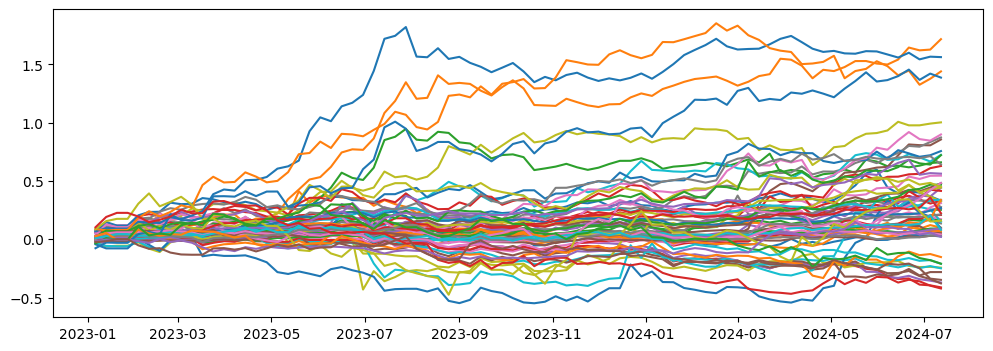

In [11]:
all = pct_close_w[pct_close_w.columns.intersection(factor.columns)].loc['2023-01-01':]
all_cumsum = all.cumsum()
plt.figure(figsize=(12,4))
plt.plot(all_cumsum)
plt.show()

In [18]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    long_only_weighting = weighting[weighting > 0].fillna(0.0)*2
    return long_only_weighting

quantile = 6
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i:i+int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-1)

index = factor.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        
        
        # factor quantilize => weighting => * pct
    weighting = get_demean_weighting(df_1)
    
    ret = pct_close_w_corres.loc[weighting.index[0]:] * weighting
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

<Axes: xlabel='da1'>

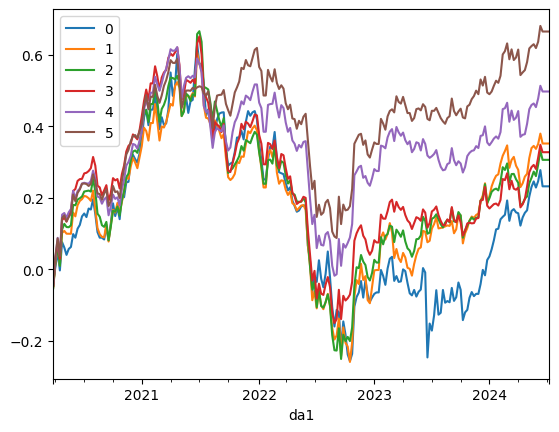

In [19]:
quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot()

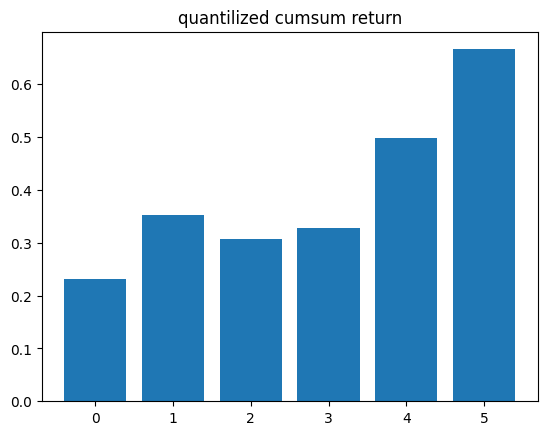

In [20]:
plt.bar(quantilized_cumsum.columns, quantilized_cumsum.iloc[-1, :])
plt.title("quantilized cumsum return")
plt.show()

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

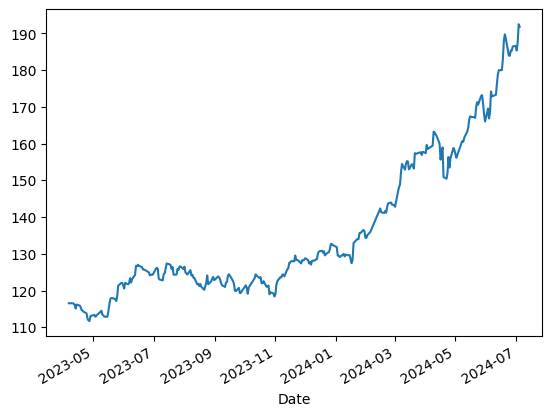

In [13]:
import yfinance as yf
zero_50 = yf.download("0050.TW", start='2023-04-01')
zero_50['Adj Close'].plot()

In [14]:
factor.to_parquet("factor_ARMA_0050_2023apr.parquet")